In [1]:
train_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Train' 
val_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Val' 
test_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Test'

In [2]:
#ELEGIMOS LOS PARAMETROS
from keras.preprocessing.image import ImageDataGenerator
ih, iw = 229,229 #tamano de la imagen
input_shape = (ih, iw, 3) #forma de la imagen: alto ancho y numero de canales

num_class = 2 #cuantas clases 
#epochs = 15 #cuantas veces entrenar. En cada epoch hace una mejora en los parametros

batch_size = 32 #batch para hacer cada entrenamiento. Lee 50 'batch_size' imagenes antes de actualizar los parametros. Las carga a memoria
num_train = 21715 #numero de imagenes en train
num_test = 6788 #numero de imagenes en test
num_val=5417

epoch_steps = num_train // batch_size 
test_steps = num_test // batch_size
 

Using TensorFlow backend.


In [3]:
#LEEMOS LAS IMÁGENES 

img_height, img_width=ih, iw

train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=15, 
                                   horizontal_flip=True,brightness_range=[0.4,1.5])

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as training data

validation_generator = train_datagen.flow_from_directory(
    val_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

test_generator = train_datagen.flow_from_directory(
    test_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

Found 14507 images belonging to 2 classes.
Found 3615 images belonging to 2 classes.
Found 4535 images belonging to 2 classes.


In [4]:
train=train_generator
val=validation_generator
test=test_generator

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, DenseNet121, ResNet50, NASNetLarge
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2

resnet50_model = ResNet50(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

#resnet50_model.trainable=True

In [6]:
import keras
output = resnet50_model.layers[-1].output 
#output = keras.layers.Flatten()(output) 
resnet50_model = Model(resnet50_model.input, output) 

 
resnet50_model.trainable = True

#for layer in resnet50_model.layers[:-2]:
#   layer.trainable = False

In [7]:
import pandas as pd 
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in resnet50_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\elium\.conda\envs\tfGPU\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000016996F475C8>,input_1,True
1,<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x00000169970B1908>,conv1_pad,True
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000016996F3EBC8>,conv1_conv,True
3,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x0000016997890888>,conv1_bn,True
4,<tensorflow.python.keras.layers.core.Activation object at 0x000001699DB9C548>,conv1_relu,True
...,...,...,...
170,<tensorflow.python.keras.layers.core.Activation object at 0x0000016C685A25C8>,conv5_block3_2_relu,True
171,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000016C685A7A88>,conv5_block3_3_conv,True
172,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x0000016C685FC908>,conv5_block3_3_bn,True
173,<tensorflow.python.keras.layers.merge.Add object at 0x0000016C685FDC08>,conv5_block3_add,True


In [8]:
resnet50_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 229, 229, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 235, 235, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 115, 115, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 115, 115, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [9]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [12]:

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical 
from keras import optimizers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
# build model architecture 
model = Sequential()
model.add(resnet50_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_class, activation='sigmoid'))
#compile model1e-3
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy',f1_m,precision_m, recall_m])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                

In [13]:
history = model.fit_generator(train, steps_per_epoch=32, 
                              epochs=25,  
                              validation_data=val,   
                              validation_steps=32,  
                              verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 32 steps, validate for 32 steps
Epoch 1/25
32/32 [==============================] - 26s 819ms/step - loss: 0.3851 - accuracy: 0.9355 - f1_m: 0.9364 - precision_m: 0.9313 - recall_m: 0.9443 - val_loss: 0.6749 - val_accuracy: 0.6172 - val_f1_m: 0.6184 - val_precision_m: 0.6139 - val_recall_m: 0.6230
Epoch 2/25
32/32 [==============================] - 20s 617ms/step - loss: 0.3765 - accuracy: 0.9326 - f1_m: 0.9334 - precision_m: 0.9240 - recall_m: 0.9434 - val_loss: 0.6232 - val_accuracy: 0.6836 - val_f1_m: 0.6856 - val_precision_m: 0.6792 - val_recall_m: 0.6924
Epoch 3/25
32/32 [==============================] - 21s 647ms/step - loss: 0.3666 - accuracy: 0.9424 - f1_m: 0.9435 - precision_m: 0.9408 - recall_m: 0.9463 - val_loss: 0.5171 - val_accuracy: 0.7773 - val_f1_m: 0.7793 - val_precision_m: 0.7794 - val_recall_m: 0.7793
Epoch 4/25
32/32 [==============================] - 21s 656ms/step - loss: 0.3788 - accuracy: 0.9326 - f1_m

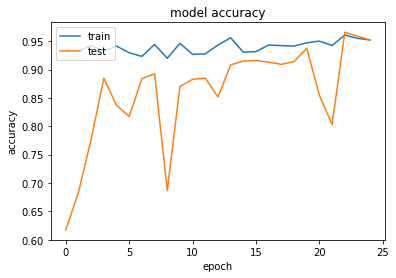

In [14]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

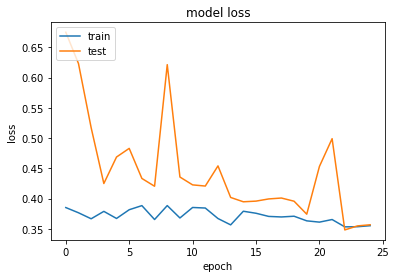

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

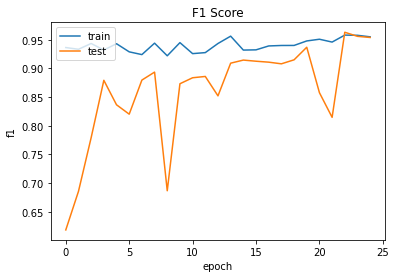

In [16]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

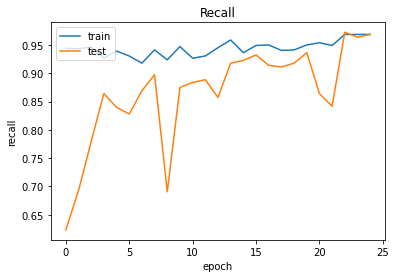

In [17]:
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

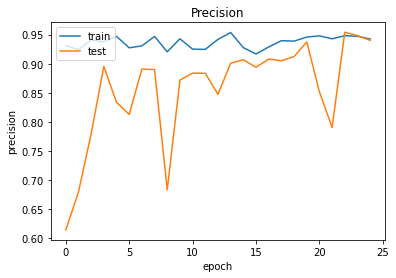

In [18]:
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

Utilizando el conjunto de datos de test para evaluar el modelo
  ...
    to  
  ['...']
142/142 [==============================] - 42s 299ms/step - loss: 0.3516 - accuracy: 0.9619 - f1_m: 0.9593 - precision_m: 0.9459 - recall_m: 0.9736
El modelo predice el  96.18522524833679 % de los datos


In [20]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
print('Loss: ',test_eval[0])
print('Accuracy: ',test_eval[1])
print('F1 Score: ',test_eval[2])
print('Precision: ',test_eval[3])
print('Recall: ',test_eval[4])

Utilizando el conjunto de datos de test para evaluar el modelo
Loss:  0.3516166927948804
Accuracy:  0.96185225
F1 Score:  0.9593471
Precision:  0.94585395
Recall:  0.97359157


Esta parte ya no importa mucho, sólo lo de arriba

In [21]:
articulo_dir='D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Implementacion/Deteccion_Articulo/dataset,solocovid,pneumonia'
#Para el conjunto del artículo
articulo_generator = train_datagen.flow_from_directory(
    articulo_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data
articulo=articulo_generator

Found 351 images belonging to 2 classes.


In [22]:
print('Utilizando el conjunto de datos del artículo para evaluar el modelo')
test_eval = model.evaluate(articulo, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

Utilizando el conjunto de datos del artículo para evaluar el modelo
  ...
    to  
  ['...']
11/11 [==============================] - 8s 731ms/step - loss: 0.4799 - accuracy: 0.8234 - f1_m: 0.8332 - precision_m: 0.8055 - recall_m: 0.8634
El modelo predice el  82.33618140220642 % de los datos


In [23]:
print('Utilizando el conjunto de datos del artículo para evaluar el modelo')
print('Loss: ',test_eval[0])
print('Accuracy: ',test_eval[1])
print('F1 Score: ',test_eval[2])
print('Precision: ',test_eval[3])
print('Recall: ',test_eval[4])

Utilizando el conjunto de datos del artículo para evaluar el modelo
Loss:  0.4798532155427066
Accuracy:  0.8233618
F1 Score:  0.833208
Precision:  0.805537
Recall:  0.8633614


In [24]:
pred=model.predict(articulo)

In [25]:
#Aquí sólo hago con  un predict con el modelo y los datos del artículo
import numpy as np
suma=0
for i in range (351):
    if np.argmax(pred[i])==0:
        suma=suma+1
print(suma)

139
